# Proje: Akciğer Kanseri BT Görüntü Sınıflandırma

**Amaç:**  Bu proje, Bilgisayarlı Tomografi (BT) görüntüleri üzerinden akciğer kanseri türlerini sınıflandırmayı hedefler. Veri seti, farklı kanser türlerini içeren alt klasörlere ayrılmıştır.

**Yaklaşım:** Bu bir görüntü sınıflandırma problemidir. Çözüm için, transfer öğrenme tekniğiyle önceden eğitilmiş bir ResNet50 modeli kullanılacaktır. Proje, veri ön işleme, veri artırma, modelin oluşturulması, eğitimi ve değerlendirilmesi aşamalarından oluşmaktadır.

# Adım 1: Gerekli Kütüphaneleri Import Etme, Sabit Değişkenleri Atama ve GPU'yu Test Etme

In [17]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications import resnet50
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, TensorBoard, ReduceLROnPlateau 
import matplotlib.pyplot as plt
import os
import shutil 
import datetime

<h3> Sabitler ve Dosya Yolları </h3>
Metrikleri hızlıca değiştirmek için projeye eklenen sabitler ve dosya yolları

In [18]:
IMAGE_SIZE = 224
BATCH_SIZE = 16
EPOCHS = 100
N_CLASSES = 4

# Veri setinizin ana klasör yapısını buraya girin
BASE_DATA_PATH = '../BrainCancerClassification/BrainCancerClassification/Data/ChestCancerCT'

train_path = os.path.join(BASE_DATA_PATH, 'train')
valid_path = os.path.join(BASE_DATA_PATH, 'valid')
test_path = os.path.join(BASE_DATA_PATH, 'test')

# Model ve Log kayit dosya yollari
output_dir = 'ML-Models' 
ModelName = 'ResNet50_chestcancer_classifier.h5'
logs_directory = 'Logs-of-ChestCancer-Resnet50'

# Her çalıştırmada eski logları temizle
if os.path.exists(logs_directory):
    shutil.rmtree(logs_directory)
os.makedirs(logs_directory)

model_path = os.path.join(output_dir, ModelName)


<h3> Ekran Kartı Testi ve Karma Hassasiyet Kurulumu(float16)</h3>

In [19]:
print("--- Setting up GPU memory ---")
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)
print("--- GPU setup complete ---")

policy = tf.keras.mixed_precision.Policy('mixed_float16')
tf.keras.mixed_precision.set_global_policy(policy)

--- Setting up GPU memory ---
1 Physical GPUs, 1 Logical GPUs
--- GPU setup complete ---


# Adım 2: Veri Jeneratörlerinin Oluşturulması



In [20]:
print("\n--- Veri Jeneratörleri Oluşturuluyor ---")

train_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=resnet50.preprocess_input,
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    brightness_range=[0.9, 1.1],
    fill_mode='nearest',
    validation_split=0.2
)

valid_test_datagen = ImageDataGenerator(
    dtype='float32',
    preprocessing_function=resnet50.preprocess_input
)

train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

valid_generator = valid_test_datagen.flow_from_directory(
    valid_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical'
)

test_generator = valid_test_datagen.flow_from_directory(
    test_path,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False
)

print("--- Veri Jeneratörleri Hazır ---")


--- Veri Jeneratörleri Oluşturuluyor ---
Found 613 images belonging to 4 classes.
Found 72 images belonging to 4 classes.
Found 315 images belonging to 4 classes.
--- Veri Jeneratörleri Hazır ---


# Adım 3: Özelleştirilmiş ResNet50 Modelinin Oluşturulması ve Derlenmesi

In [21]:
print("\n--- Transfer Öğrenme Modeli Oluşturuluyor ---")

base_model = ResNet50(
    weights='imagenet',
    include_top=False,
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

for layer in base_model.layers:
    if 'conv5' not in layer.name:
        layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.5)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
predictions = Dense(N_CLASSES, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=predictions)

optimizer = Adam(learning_rate=0.0001, decay=1e-5) 
model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("--- Model Mimarisi ---")
model.summary()



--- Transfer Öğrenme Modeli Oluşturuluyor ---
--- Model Mimarisi ---
Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_3[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                      

# Adım 4: Geri Çağırmaların (Callbacks) Tanımlanması

Bu adımda, modelin eğitim sürecinde daha sağlam ve genellenebilir olmasını sağlamak amacıyla, mevcut eğitim verilerine ImageDataGenerator kullanılarak veri artırımı (Data Augmentation) uygulanır.

In [ ]:
print("\n--- Geri Çağırmalar Tanımlanıyor ---")

# En iyi modeli kaydetmek için Checkpoint
checkpoint = ModelCheckpoint(
    filepath=model_path, 
    monitor='val_accuracy',
    verbose=1,
    save_best_only=True,
    mode='max'
)

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=5,
    verbose=1,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.2,
    patience=3,
    min_lr=1e-7,
    verbose=1
)

log_dir = os.path.join(logs_directory, datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)


callbacks_list = [checkpoint, early_stopping, tensorboard_callback, reduce_lr] 
print("--- Geri Çağırmalar Hazır ---")



--- Geri Çağırmalar Tanımlanıyor ---
--- Geri Çağırmalar Hazır ---


# Adım 5: Modeli Eğitme

Bu adımda, görüntü sınıflandırma için önceden eğitilmiş ResNet50 modeli kullanılır ve transfer öğrenme amacıyla üst katmanı çıkarılır. Çıkarılan bu katman yerine, yeni bir sınıflandırma başlığı eklenir. Son olarak, model Adam optimizer ile derlenerek eğitime hazır hale getirilir.

In [23]:
%load_ext tensorboard
%tensorboard --logdir {logs_directory}

print("\n--- Model Eğitimi Başlatılıyor ---")

history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=valid_generator,
    validation_steps=valid_generator.samples // BATCH_SIZE,
    callbacks=callbacks_list,
    verbose=1
)

print("--- Model Eğitimi Tamamlandı ---")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


Reusing TensorBoard on port 6006 (pid 13064), started 7:59:33 ago. (Use '!kill 13064' to kill it.)


--- Model Eğitimi Başlatılıyor ---
Epoch 1/100
38/38 [==============================] - ETA: 0s - loss: 1.4759 - accuracy: 0.4405
Epoch 1: val_accuracy improved from -inf to 0.51562, saving model to ML-Models\ResNet50_chestcancer_classifier.h5
38/38 [==============================] - 22s 439ms/step - loss: 1.4759 - accuracy: 0.4405 - val_loss: 1.2849 - val_accuracy: 0.5156 - lr: 1.0000e-04
Epoch 2/100
38/38 [==============================] - ETA: 0s - loss: 1.0308 - accuracy: 0.5846
Epoch 2: val_accuracy improved from 0.51562 to 0.59375, saving model to ML-Models\ResNet50_chestcancer_classifier.h5
38/38 [==============================] - 15s 397ms/step - loss: 1.0308 - accuracy: 0.5846 - val_loss: 1.0448 - val_accuracy: 0.5938 - lr: 1.0000e-04
Epoch 3/100
38/38 [==============================] - ETA: 0s - loss: 0.8152 - accuracy: 0.6767
Epoch 3: val_accuracy did not improve from 0.59375
38/38 [==============================] - 14s 377ms/step - loss: 0.8152 - accuracy: 0.6767 - val_los

# Adım 6: Eğitim Performansının Görselleştirilmesi



--- Eğitim Sonuçları Görselleştiriliyor ---


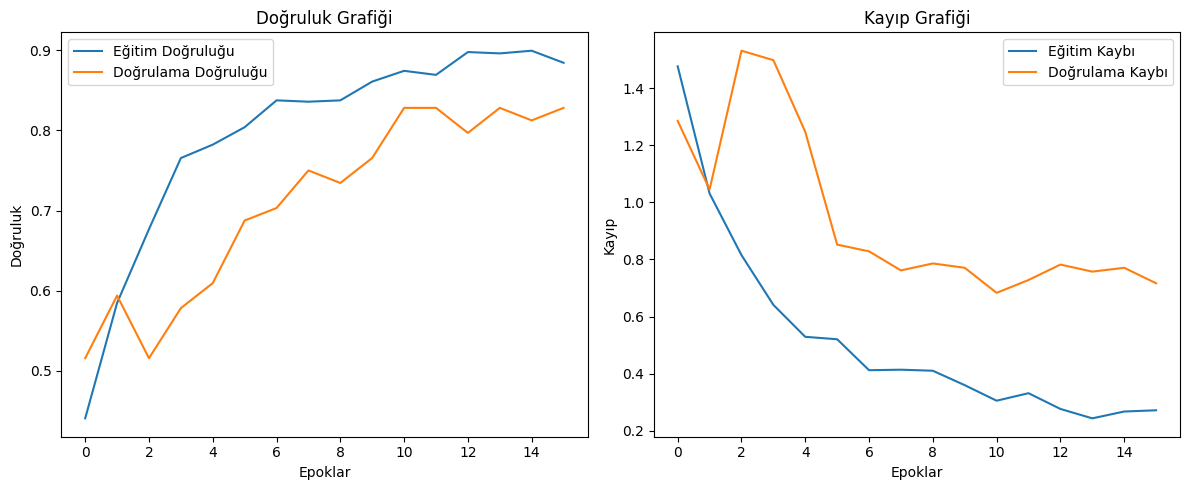

In [24]:
print("\n--- Eğitim Sonuçları Görselleştiriliyor ---")

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Eğitim Doğruluğu')
plt.plot(history.history['val_accuracy'], label='Doğrulama Doğruluğu')
plt.title('Doğruluk Grafiği')
plt.xlabel('Epoklar')
plt.ylabel('Doğruluk')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Eğitim Kaybı')
plt.plot(history.history['val_loss'], label='Doğrulama Kaybı')
plt.title('Kayıp Grafiği')
plt.xlabel('Epoklar')
plt.ylabel('Kayıp')
plt.legend()

plt.tight_layout()
plt.show()


# Adım 7: Modelin Test Verisiyle Değerlendirilmesi

In [25]:
print("\n--- Model Test Verisiyle Değerlendiriliyor ---")

test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // BATCH_SIZE)

print(f"\nTest Verisi Kayıp (Loss): {test_loss:.4f}")
print(f"Test Verisi Doğruluk (Accuracy): {test_accuracy:.4f}")


--- Model Test Verisiyle Değerlendiriliyor ---
19/19 [==============================] - 1s 70ms/step - loss: 0.6246 - accuracy: 0.7862

Test Verisi Kayıp (Loss): 0.6246
Test Verisi Doğruluk (Accuracy): 0.7862
